# Projet ADEME : Recherche opérationnelle

## Préparation de l'environnement

### Importation des librairies

In [27]:
# Importer les bibliothèques nécessaires
import pulp
import random
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
import pandas as pd
import time
import copy

### Fonctions générales

- **generate_graph** : Génère un graphe aléatoire complet de $n$ sommets avec des poids de ditance et de temps sur les arrêtes. Il resteint les arrêtes en leur donnant un poids de 999 selon une certaine probabilité (1%).
- **draw_graph** : Affiche le graphe $G$ avec les solutions de routes si elles existent.
- **print_solution** : Affiche la distance totale et le temps maximum des camions ainsi qu'un tableau avec la distance, le temps et la tournée de chaque camion.

In [28]:
def generate_graph(n, restriction_probability=0.1, distance_range=(1, 100), time_range=(1, 60)):
    # Crée un graphe complet avec n sommets
    G = nx.complete_graph(n)

    # Parcourt toutes les arêtes du graphe
    for u, v in G.edges():
        # Pour chaque arête, on attribue une distance et un temps
        # Avec une probabilité 'restriction_probability', on met une valeur élevée (999) pour simuler une contrainte
        G[u][v]['distance'] = 999 if random.random() < restriction_probability else random.randint(*distance_range)
        G[u][v]['time'] = 999 if random.random() < restriction_probability else random.randint(*time_range)

    return G

def draw_graph(G, routes=None, depots=[0], title="Graphe complet généré aléatoirement"):
    # Calcule les positions des nœuds pour affichage (mise en page stable grâce à seed=42)
    pos = nx.spring_layout(G, seed=42)

    # Prépare les étiquettes des arêtes avec distance et temps
    edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}

    plt.figure(figsize=(8, 5))
    plt.title(title)

    # Affiche les nœuds : verts pour les dépôts, bleus sinon
    nx.draw_networkx_nodes(G, pos, node_color=['lightgreen' if n in depots else 'lightblue' for n in G.nodes], node_size=250)

    # Affiche les étiquettes des nœuds (identifiants)
    nx.draw_networkx_labels(G, pos, font_size=7)

    # Affiche les arêtes en gris clair par défaut
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Si des routes sont fournies, on les dessine en couleurs plus visibles
    if routes:
        line_color = ["red", "blue", "green", "orange", "purple"]
        for k, edges in enumerate(routes):
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])

    # Affiche les étiquettes des arêtes (distance et temps)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.show()

def print_solution(G, routes, depot=0):
    # Calcule les coûts globaux (somme des distances et des temps)
    total_distance = sum(G.edges[u, v]['distance'] for edges in routes for u, v in edges)
    total_time = max(sum(G.edges[u, v]['time'] for u, v in edges) for edges in routes)

    # Affiche le résumé global
    print("\n\033[1mRÉSUMÉ GLOBAL\033[0m")
    print(f"Distance totale : {total_distance}")
    print(f"Temps max       : {total_time}")

    # En-tête du tableau
    header = f"\n\033[1m{'Camion':<8}{'Distance':>12}{'Temps':>10}   Tournée\033[0m"
    print(header)
    print("-" * (len(header) - 11))

    # Affiche le détail de chaque tournée (par camion)
    for k, edges in enumerate(routes):
        # Calcule la distance et le temps pour chaque camion
        dist = sum(G.edges[u, v]['distance'] for u, v in edges)
        t = sum(G.edges[u, v]['time'] for u, v in edges)

        # --- tentative de reconstruction du chemin dans l'ordre ---
        path = [depot]
        remaining = edges.copy()
        while remaining:
            for idx, (i, j) in enumerate(remaining):
                if i == path[-1]:
                    path.append(j)
                    remaining.pop(idx)
                    break
                elif j == path[-1]:
                    path.append(i)
                    remaining.pop(idx)
                    break
            else:
                # Si on n'arrive pas à déterminer l'ordre du chemin, on ajoute tout ce qui reste à la suite
                path.extend([edge for pair in remaining for edge in pair])
                break

        # Affiche le chemin de la tournée sous forme lisible
        path_str = " → ".join(map(str, path))
        print(f"{k:<8}{dist:>12}{t:>10}   {path_str}")

## Génération d'un graphe aléatoire $G$ pour le reste de la présentation

### Modification de la Seed à chaque lancement du code

In [29]:
# Génère une graine aléatoire entre 0 et 100000
seed = random.randint(0, 100000)

# Initialise le générateur de nombres aléatoires avec cette graine
# Cela permet de reproduire exactement les mêmes résultats si on relance le programme avec la même seed
random.seed(seed)

# Affiche la seed utilisée pour pouvoir la réutiliser si besoin
print(f"Seed : {seed}")

Seed : 82992


### Graphe généré à partir de la seed

Ce graphe sera utilisé tout au long de la présentation pour comparer les différents algorithmes.

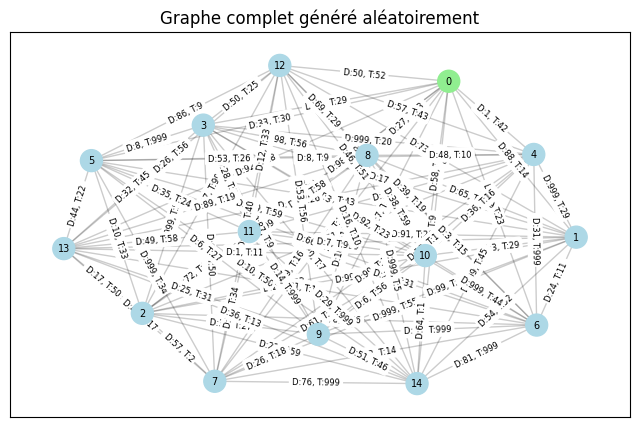

In [30]:
# Nombre de sommets (villes ou points à visiter)
N = 15

# Génération d'un graphe complet avec 15 sommets
# Chaque arête reçoit une distance et un temps aléatoires
G = generate_graph(N)

# Affichage du graphe généré avec les distances et temps sur les arêtes
draw_graph(G)

## Resolution du problème grâce à la **programmation linéaire**

Cet algorithme donne la solution optimale au problème en utilisant la librairie Pulp de python.

In [31]:
def PL_vrp(G, K, depot=0):
    customers = [v for v in G.nodes if v != depot]      # Sommets à visiter
    m = len(customers)                                  # Nombre de clients
    L = m // K                                          # Nombre minimum de clients par camion
    U = L if m % K == 0 else L + 1                      # Nombre maximum de clients par camion

    arcs = [(i, j) for i in G.nodes for j in G.nodes if i != j]

    # --- Définir le problème --- #
    prob = pulp.LpProblem("Distance_VRP", pulp.LpMinimize)

    # --- Variables de décision --- #
    # x[i,j,k] = 1 si le camion k prend l'arc (i,j), 0 sinon
    # u[i,k] = Nombre de clients visités par le camion k avant le client i
    x = pulp.LpVariable.dicts("x", ((i, j, k) for (i, j) in arcs for k in range(K)), lowBound=0, upBound=1, cat="Binary")
    u = pulp.LpVariable.dicts("u", ((i, k) for i in customers for k in range(K)), lowBound=1, upBound=m, cat="Integer")

    # --- Fonction objectif : minimiser la distance totale parcourue --- #
    prob += pulp.lpSum(G.edges[i, j]["distance"] * x[(i, j, k)] for (i, j) in arcs for k in range(K))

    # --- Contraintes --- #
    # Chaque client exactement une fois
    for i in customers:
        prob += pulp.lpSum(x[(i, j, k)] for j in G.nodes if j != i for k in range(K)) == 1

    # Un départ & un retour dépôt par camion
    for k in range(K):
        prob += pulp.lpSum(x[(0, j, k)] for j in customers) == 1
        prob += pulp.lpSum(x[(i, 0, k)] for i in customers) == 1

    # Conservation du flux
    for k in range(K):
        for v in customers:
            prob += (pulp.lpSum(x[(i, v, k)] for i in G.nodes if i != v) - pulp.lpSum(x[(v, j, k)] for j in G.nodes if j != v)) == 0

    # MTZ : élimination des sous-tours
    for k in range(K):
        for i, j in itertools.permutations(customers, 2):
            prob += u[(i, k)] - u[(j, k)] + m * x[(i, j, k)] <= m - 1

    # Équilibrage (même nombre de clients ±1 par camion)
    # L = m // K, U = L + 1 si m % K != 0
    # L <= nombre de clients par camion <= U
    for k in range(K):
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) >= L
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) <= U

    # Résolution
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # Récupération des arêtes sélectionnées pour chaque camion
    routes = [[] for _ in range(K)]
    for k in range(K):
        for i, j in arcs:
            if pulp.value(x[(i, j, k)]) > 0.5:
                routes[k].append((i, j))

    return routes, pulp.value(prob.objective)


RÉSUMÉ GLOBAL
Distance totale : 209
Temps max       : 1243

Camion      Distance     Temps   Tournée
--------------------------------------
0                 85      1243   0 → 3 → 5 → 2 → 14 → 12 → 11 → 4 → 0
1                124       139   0 → 9 → 8 → 6 → 1 → 10 → 13 → 7 → 0


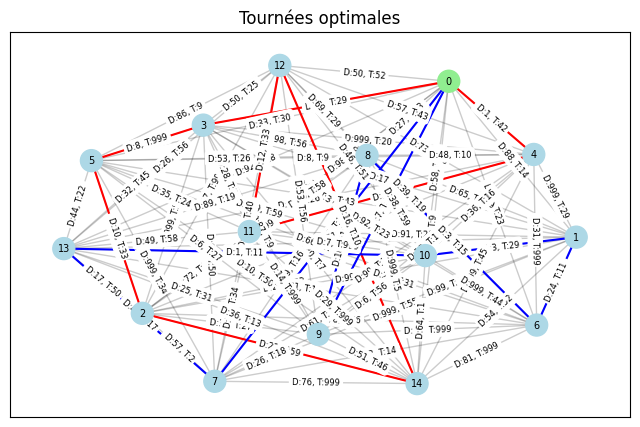

In [32]:
# Cette fonction retourne les routes optimisées et la distance totale minimale.
routes, total_distance = PL_vrp(G, 2)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution(G, routes)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, routes, title="Tournées optimales")

## Resolution du problème grâce à la **l'algorithme tabou**

In [ ]:
def smart_initial_solution(graph, nombre_camion, depot):
    nodes = list(graph.nodes())
    nodes.remove(depot)
    
    # Trier les clients selon leur distance au dépôt
    nodes.sort(key=lambda node: graph[depot][node]['distance'] if graph.has_edge(depot, node) else graph[node][depot]['distance'])

    # Répartition équilibrée des clients entre les camions
    split = [len(nodes) // nombre_camion] * nombre_camion
    for i in range(len(nodes) % nombre_camion):
        split[i] += 1

    # Construction des routes pour chaque camion
    solution = []
    idx = 0
    for s in split:
        route = [depot] + nodes[idx:idx+s] + [depot]
        idx += s
        solution.append(route)
    return solution


def calculate_cost(graph, solution):
    total_cost = 0
    for route in solution:
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if graph.has_edge(u, v):
                total_cost += graph[u][v]['distance']
            elif graph.has_edge(v, u):
                total_cost += graph[v][u]['distance']
            else:
                total_cost += 9999  # pénalité si arc manquant
    return total_cost


def tabu_search(graph, nombre_camion, depot=0, iterations=500, tabu_tenure=15):
    solution = smart_initial_solution(graph, nombre_camion, depot)  # Solution initiale
    best_solution = [route[:] for route in solution]  # Copie superficielle
    best_cost = calculate_cost(graph, best_solution)
    tabu_list = []

    courantes = []              # Coûts courants à chaque itération
    meilleures_courantes = []   # Meilleurs coûts globaux

    for _ in range(iterations):
        neighborhood = []

        # Génération du voisinage : échange de clients entre camions
        for i in range(nombre_camion):
            for j in range(1, len(solution[i]) - 1):  # Ne pas échanger le dépôt
                for k in range(nombre_camion):
                    if i != k:
                        for l in range(1, len(solution[k]) - 1):
                            neighbor = [route[:] for route in solution]
                            neighbor[i][j], neighbor[k][l] = neighbor[k][l], neighbor[i][j]

                            # Vérification tabou
                            if neighbor not in tabu_list:
                                neighborhood.append((neighbor, calculate_cost(graph, neighbor)))

        if not neighborhood:
            break

        # Sélection du meilleur voisin
        neighborhood.sort(key=lambda x: x[1])
        solution, current_cost = neighborhood[0]

        if current_cost < best_cost:
            best_solution = [route[:] for route in solution]
            best_cost = current_cost

        # Mise à jour de la liste tabou
        tabu_list.append(solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        # Suivi des évolutions
        courantes.append(current_cost)
        meilleures_courantes.append(best_cost)

    # Conversion des routes en listes d’arêtes pour affichage
    routes = []
    for route in best_solution:
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        routes.append(edges)
    return routes, best_cost, courantes, meilleures_courantes

SyntaxError: unterminated string literal (detected at line 87) (1056302912.py, line 87)

In [ ]:
# Utilisation de l’algorithme
best_solution, best_cost, courantes, meilleures_courantes = tabu_search(G, nombre_camion=2, depot=0)

# Affichage de la solution trouvée
print_solution(G, best_solution, depot=0)
draw_graph(G, best_solution, title="Solution VRP avec recherche Tabou")